In [1]:
import pandas as pd
import sys
from datetime import date, datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Data Preparation (general)

In [2]:

sys.path.insert(0,"..")
df = pd.read_csv("../data/processed/trips_weather.csv", index_col=0)
df = df.sort_values(by=['start_time'], ascending=True)
df["start_time"] = pd.to_datetime(df["start_time"])

In [3]:
for col in ['start_time']:
    df['month'] = pd.DatetimeIndex(df['start_time']).month
    df['booking_date'] = df.start_time.dt.date
    df['weekdays'] = pd.DatetimeIndex(df['start_time']).weekday
    df['hour'] = pd.DatetimeIndex(df['start_time']).hour

In [4]:
df['duration_min'] = df['duration_sec']/60
df['number_bookings'] = 1

In [5]:
display(df.nunique(),df.info(),df.head(2), df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143665 entries, 0 to 143664
Data columns (total 34 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   bike_type           143665 non-null  int64         
 1   identification      143665 non-null  int64         
 2   start_time          143665 non-null  datetime64[ns]
 3   end_time            143665 non-null  object        
 4   duration_sec        143665 non-null  float64       
 5   start_lng           143665 non-null  float64       
 6   start_lat           143665 non-null  float64       
 7   end_lng             143665 non-null  float64       
 8   end_lat             143665 non-null  float64       
 9   start_place         143665 non-null  int64         
 10  end_place           143665 non-null  int64         
 11  start_plz           143665 non-null  int64         
 12  end_plz             143665 non-null  int64         
 13  month               143665 no

bike_type                  2
identification        111421
start_time            110186
end_time              108021
duration_sec            1307
start_lng              51182
start_lat              13513
end_lng                48071
end_lat                 8461
start_place               76
end_place                 76
start_plz                 33
end_plz                   33
month                     11
booking_date             312
weekdays                   7
duration_min            1307
start_name                73
end_name                  73
timestamp              35307
temp_2m                  421
humidity_2m              794
dew_point_2m             290
max_at_2m                421
mean_speed_h/s           153
direction_degree_x        37
max_m/s                  143
min_mean_m/s              61
max_mean_m/s             161
direction_degree_y        37
min                       11
mm                       116
hour                      24
number_bookings            1
dtype: int64

None

,bike_type,identification,start_time,end_time,duration_sec,start_lng,start_lat,end_lng,end_lat,start_place,...,mean_speed_h/s,direction_degree_x,max_m/s,min_mean_m/s,max_mean_m/s,direction_degree_y,min,mm,hour,number_bookings
0,71,12099440,2019-01-20 00:13:00,2019-01-20 00:23:00,600.0,8.812554,53.076481,8.804828,53.084196,0,...,2.6,80.0,3.1,2.1,2.6,80.0,0.0,0.0,0,1
1,71,10278649,2019-01-20 00:16:00,2019-01-20 04:47:00,16260.0,8.884911,53.078923,8.884911,53.078923,2985,...,2.6,80.0,3.1,2.1,2.6,80.0,0.0,0.0,0,1


bike_type                  0
identification             0
start_time                 0
end_time                   0
duration_sec               0
start_lng                  0
start_lat                  0
end_lng                    0
end_lat                    0
start_place                0
end_place                  0
start_plz                  0
end_plz                    0
month                      0
booking_date               0
weekdays                   0
duration_min               0
start_name            107572
end_name              112345
timestamp                739
temp_2m                  739
humidity_2m              739
dew_point_2m             739
max_at_2m                739
mean_speed_h/s           739
direction_degree_x       739
max_m/s                  739
min_mean_m/s             739
max_mean_m/s             739
direction_degree_y       739
min                      739
mm                       739
hour                       0
number_bookings            0
dtype: int64

In [6]:
#drop unnecessary columns
df.drop(columns=["start_name", "end_name","identification", "end_time", "end_lng", "end_lat", "end_place", "end_plz", "booking_date", "timestamp"], inplace=True)

df.head(2)

,bike_type,start_time,duration_sec,start_lng,start_lat,start_place,start_plz,month,weekdays,duration_min,...,mean_speed_h/s,direction_degree_x,max_m/s,min_mean_m/s,max_mean_m/s,direction_degree_y,min,mm,hour,number_bookings
0,71,2019-01-20 00:13:00,600.0,8.812554,53.076481,0,28195,1,6,10.0,...,2.6,80.0,3.1,2.1,2.6,80.0,0.0,0.0,0,1
1,71,2019-01-20 00:16:00,16260.0,8.884911,53.078923,2985,28329,1,6,271.0,...,2.6,80.0,3.1,2.1,2.6,80.0,0.0,0.0,0,1


In [7]:
df.isna().sum()

bike_type               0
start_time              0
duration_sec            0
start_lng               0
start_lat               0
start_place             0
start_plz               0
month                   0
weekdays                0
duration_min            0
temp_2m               739
humidity_2m           739
dew_point_2m          739
max_at_2m             739
mean_speed_h/s        739
direction_degree_x    739
max_m/s               739
min_mean_m/s          739
max_mean_m/s          739
direction_degree_y    739
min                   739
mm                    739
hour                    0
number_bookings         0
dtype: int64

## Data preparation for feature selection

In [8]:
#data by timespan 24H, 1H, 4H, 12H
def setDataset(dataset, temp_resol, columnnamegroupby, functions_dic):
    newDataset = dataset.resample(temp_resol, on =columnnamegroupby).agg(functions_dic)
    
    return newDataset

In [9]:
df_24h = setDataset(df, "24H", "start_time", {"number_bookings":"count", "month":"mean","weekdays": "mean","temp_2m":"mean",  "humidity_2m":"mean", "dew_point_2m":"mean","max_at_2m":"mean","mean_speed_h/s":"mean", "direction_degree_x":"mean",  "max_m/s":"mean","min_mean_m/s":"mean", "max_mean_m/s":"mean", "direction_degree_y":"mean", "min":"mean", "mm":"mean", "hour":"mean"})
#chosen columns: bike_type, month, weekdays, hour and weather data

In [10]:
df_24h.isna().sum()

number_bookings        0
month                 34
weekdays              34
temp_2m               34
humidity_2m           34
dew_point_2m          34
max_at_2m             34
mean_speed_h/s        34
direction_degree_x    34
max_m/s               34
min_mean_m/s          34
max_mean_m/s          34
direction_degree_y    34
min                   34
mm                    34
hour                  34
dtype: int64

In [11]:
#Null values stem from the month of july (1st - 31st) and previously dropped days of march (16th, 17th, 18th)
df_24h[df_24h.isna().any(axis=1)]

,number_bookings,month,weekdays,temp_2m,humidity_2m,dew_point_2m,max_at_2m,mean_speed_h/s,direction_degree_x,max_m/s,min_mean_m/s,max_mean_m/s,direction_degree_y,min,mm,hour
start_time,,,,,,,,,,,,,,,,
2019-03-16,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-17,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-18,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-01,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-02,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-03,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-04,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-05,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-06,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
df_24h.dropna(axis=0, inplace=True)

## Feature selection

#### Which features are higly correlated to number_bookings?

In [13]:
df_24h.corrwith(df_24h['number_bookings'])

number_bookings       1.000000
month                 0.332267
weekdays             -0.052235
temp_2m               0.721636
humidity_2m          -0.426555
dew_point_2m          0.607485
max_at_2m             0.723021
mean_speed_h/s       -0.152614
direction_degree_x   -0.066278
max_m/s              -0.123233
min_mean_m/s         -0.213726
max_mean_m/s         -0.140546
direction_degree_y   -0.065191
min                  -0.424720
mm                   -0.258944
hour                  0.277167
dtype: float64

#### Features which are correlated to number of bookings:
datetime related
- month is correlated
- hour is correlated
- weekdays is not correlated

weather related
- temp_2m is very highly correlated
- humidity_2m is highly correlated
- dew_point is very highly correlated
- min_mean_m/s (min wind speed m/s) is correlated
- max_at_2m (max temp) is very highly correlated
- min (rain minutes) is highly correlated
- mm (rain mm) is correlated
- other features are not correlated

#### Which weather features should we use?
Correlation matrix of weather related features:

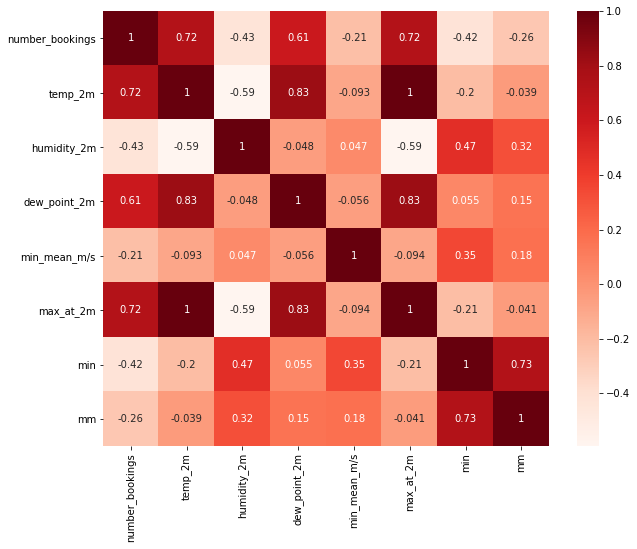

In [14]:
#Using Pearson Correlation for everything with corr above |0.1| to number_bookings
plt.figure(figsize=(10,8))
cor = df_24h[['number_bookings','temp_2m','humidity_2m',"dew_point_2m","min_mean_m/s","max_at_2m", "min", "mm"   ]].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

#### Findings:
- max_at_2m and temp_2m are basically the same
- dew_point_2m is very highly correlated to max_at_2m as well as temp_2m (0.82)
- humidity_2m is highly correlated to max_at_2m as well as temp_2m, yet has no correlation to dew_point_2m

--> Since max_at_2m and temp_2m have the same correlaiton to number_bookings, we will get rid of dew_point_2m. We expect the correlation of max_at_2m am to differ for smaller temporal resolutions, e.g. hourly datapoints. That's why we get rid of max_at_2m and decide to keep temp_2m instead. Because of its high correlation to other temperature features, we will also get rid of humidity_2m.

- min (rain) and mm (rain) are very highly correlated

--> since min (rain) has a higher correlation to number_bookings than mm (rain) we will get rid of mm (rain).

- min_mean_m/s is correlated with min (rain)

--> since min_mean_m/s provides the lowest correlation to number_bookings and is correlated to min (rain), we will get rid of min_mean_m/s


#### Which datetime features should we use?

Correlation matrix of datetime features:

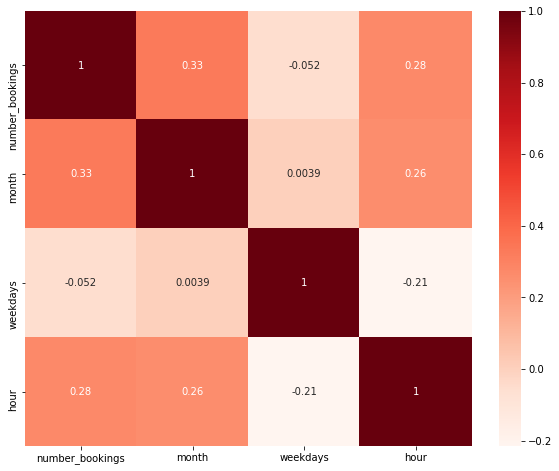

In [15]:
#Using Pearson Correlation for everything with corr above |0.1| to number_bookings
plt.figure(figsize=(10,8))
cor = df_24h[['number_bookings','month','weekdays', "hour"    ]].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

#### Findings:
- month and hour are correlated to number_bookings
- month and hour are correlated to each other

--> since month and hour have the highest correlation to number_bookings we will get rid of weekdays, we expect the correlation of hour to change with temporal resolution, which is why we keep both, hour and month as features

#### These are the features we select for our number_bookings prediction:
- hour
- month
- temp_2m
- min (rain)

As we can see, our features are not highly correlated to each other, while providing relatively high correlation to our target feature, number_bookings. The feature temp_2m.

In [16]:
features_y = ['number_bookings','month',"hour",'temp_2m', "min"]
features = ['month',"hour",'temp_2m', "min"]

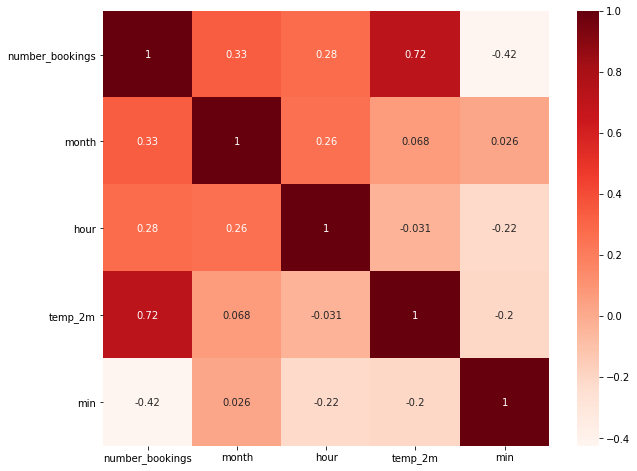

In [17]:
#Using Pearson Correlation for everything with corr above |0.1| to number_bookings
plt.figure(figsize=(10,8))
cor = df_24h[features_y].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [18]:
for col in df_24h.columns:
    pct_missing = np.mean(df_24h[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

number_bookings - 0.0%
month - 0.0%
weekdays - 0.0%
temp_2m - 0.0%
humidity_2m - 0.0%
dew_point_2m - 0.0%
max_at_2m - 0.0%
mean_speed_h/s - 0.0%
direction_degree_x - 0.0%
max_m/s - 0.0%
min_mean_m/s - 0.0%
max_mean_m/s - 0.0%
direction_degree_y - 0.0%
min - 0.0%
mm - 0.0%
hour - 0.0%


## Prediction by temporal resolution (24h, 12h, 6h, 1h)

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

#### Test set performance function:

In [35]:
def testperformance(X_train, y_train, X_val, X_test, y_val, y_test, deg, i):
    
    #merge train and val
    X_train = X_train.append(X_val)
    y_train = y_train.append(y_val)
    
    #initialize model
    poly = PolynomialFeatures(deg)
    X_train_poly = poly.fit_transform(X_train)
    
    lin = LinearRegression()
    
    #train + val performance
    lin.fit(X_train_poly, y_train)
    r2_train_val = lin.score(X_train_poly, y_train)
    mae_train_val = mean_absolute_error(y_train, lin.predict(X_train_poly))
    
    #test performance
    X_test_poly = poly.fit_transform(X_test)
    r2_test = lin.score(X_test_poly,y_test)
    mae_test = mean_absolute_error(y_test, lin.predict(X_test_poly))
    
    print("The merged train + validataion dataset of temporal resolution ", i ," scored R2 of: ", r2_train_val.round(4), " and scored MAE of: ", mae_train_val.round(4))
    print("The test dataset of temporal resolution ", i ," scored R2 of: ", r2_test.round(4),  " and scored MAE of: ", mae_test.round(4))
    

#### Polynomial degree suggestion function:

In [36]:
#this function chooses the best degree for a polynomial regression model
def chooseDegree(X, y, i):
    
    # Splitting data into train and validation set
    X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.60, shuffle=True, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.60, shuffle=True, random_state=42)

    R2_train = []
    R2_val = []
    rmses_val = []
    degrees = np.arange(1, 10)
    min_rmse, min_deg = 1e10, 0

    for deg in degrees:

        # Train features
        poly_features = PolynomialFeatures(degree=deg, include_bias=False)
        X_poly_train = poly_features.fit_transform(X_train)

        # Linear regression
        poly_reg = LinearRegression()
        poly_reg.fit(X_poly_train, y_train)
        X_val_poly = poly_features.fit_transform(X_val)
        
        # Evaluate
        R2_train.append(poly_reg.score(X_poly_train, y_train))
        R2_val.append(poly_reg.score(X_val_poly,y_val))
        
        
#         print("R2 train: ", poly_reg.score(X_poly_train, y_train))
#         print("R2 val: ", poly_reg.score(X_val_poly,y_val))

        # Compare with val data
        poly_predict = poly_reg.predict(X_val_poly)
        poly_mse = mean_squared_error(y_val, poly_predict)
        poly_rmse = np.sqrt(poly_mse)
        rmses_val.append(poly_rmse)
        
        # compare val R2 score
        poly_r2 = poly_reg.score(X_val_poly,y_val)
        
        # compare val MAE
        poly_MAE = mean_absolute_error(y_val, poly_reg.predict(X_val_poly))

        # Cross-validation of degree
        if min_rmse > poly_rmse:
            min_rmse = poly_rmse
            min_deg = deg
            max_r2 = poly_r2
            min_MAE = poly_MAE
        
        #end of degree testing? -> test performance on test set
        if deg >= 9:
            # Plot and present results
            print('Suggested degree of {} with validation set RMSE of {} and R2 of {} and MAE of {}'.format(min_deg, min_rmse.round(4), max_r2.round(4), min_MAE.round(4)))

            #test set performance
            testperformance(X_train, y_train, X_val, X_test, y_val, y_test, min_deg, i)
        
        
#     # Plot and present results
#     print('Suggested degree of {} with validation set RMSE of {} and R2 of {} '.format(min_deg, min_rmse.round(4), max_r2.round(4)))


    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
    
    #ax_rmses_val = fig.add_subplot(111)
    axes[0].plot(degrees, rmses_val, label=('rmses_val with resolution: ', i))
    axes[0].set_yscale('log')
    axes[0].set_xlabel('Degree')
    axes[0].set_ylabel('RMSE')
    
    #ax_R2_train = fig.add_subplot(111)
    axes[1].plot(degrees, R2_train, label=('R2_train with resolution: ', i))
    axes[1].set_yscale('linear')
    axes[1].set_xlabel('Degree')
    axes[1].set_ylabel('R2_train')
    axes[1].set_label('R2_train')
    axes[1].set_ylim(0, 1)
    
    #ax_R2_val = fig.add_subplot(111)
    axes[1].plot(degrees, R2_val, label='R2_val')
    axes[1].set_xlabel('Degree')
    axes[1].set_ylabel('R2_val')
    
    axes[0].legend()
    axes[1].legend()
    fig.tight_layout()

#### Temporal resolution of datasets function:

In [37]:
#data by timespan 24H, 1H, 4H, 12H
def setDataset(dataset, temp_resol, columnnamegroupby, functions_dic):
    global newDataset
    newDataset = dataset.resample(temp_resol, on =columnnamegroupby).agg(functions_dic)

In [53]:
#print out mean of number_bookings for given temporal reoslution to compare with MAE later on
temp_resol = ['24H', '12H', '6H', '1H']
for i in temp_resol:
    setDataset(df,i,"start_time", {"number_bookings":"count", "month":"mean",  "hour":"mean", "temp_2m":"mean", "min":"mean",})
    #data
    data = newDataset
    #drop null
    data.dropna(axis=0, inplace=True)
    
    mean_demand = data.number_bookings.mean()
    mean_demand = round(mean_demand,2)
    print("temporal resolution of: ", i, " has an mean number_bookings of: ", mean_demand)
    

temporal resolution of:  24H  has an mean number_bookings of:  460.46
temporal resolution of:  12H  has an mean number_bookings of:  230.28
temporal resolution of:  6H  has an mean number_bookings of:  115.41
temporal resolution of:  1H  has an mean number_bookings of:  19.76


#### Combined function to create temporal resolution datasets, determine polynomial degree and evaluate test set performance

In [38]:
def create_predict_test(dataset):
    temp_resol = ['24H', '12H', '6H', '1H']
    features = ['month',"hour",'temp_2m', "min"]
    counter = 0
    global data
    global X
    global y
    for i in temp_resol:
        counter = counter +1 # not used
        #create dataset 
        setDataset(df,i,"start_time", {"number_bookings":"count", "month":"mean",  "hour":"mean", "temp_2m":"mean", "min":"mean",})
        data = newDataset
        #drop null
        data.dropna(axis=0, inplace=True)
        
        #create features
        X = data[features]
        y = data['number_bookings']
        
        print('#################################')
        print("temporal resolution of: ", i)
        
        #train, predict, evaluate
        chooseDegree(X,y,i)

### Prediction and evaluation of number_bookings with suggested polynomial regression degrees:

#################################
temporal resolution of:  24H
Suggested degree of 1 with validation set RMSE of 77.5595 and R2 of 0.7939 and MAE of 62.5762
The merged train + validataion dataset of temporal resolution  24H  scored R2 of:  0.7355  and scored MAE of:  68.61
The test dataset of temporal resolution  24H  scored R2 of:  0.6494  and scored MAE of:  71.1781
#################################
temporal resolution of:  12H
Suggested degree of 2 with validation set RMSE of 50.5818 and R2 of 0.8069 and MAE of 38.8856
The merged train + validataion dataset of temporal resolution  12H  scored R2 of:  0.8066  and scored MAE of:  36.4226
The test dataset of temporal resolution  12H  scored R2 of:  0.7734  and scored MAE of:  36.745
#################################
temporal resolution of:  6H
Suggested degree of 3 with validation set RMSE of 39.2686 and R2 of 0.7265 and MAE of 30.5769
The merged train + validataion dataset of temporal resolution  6H  scored R2 of:  0.7677  and scored 

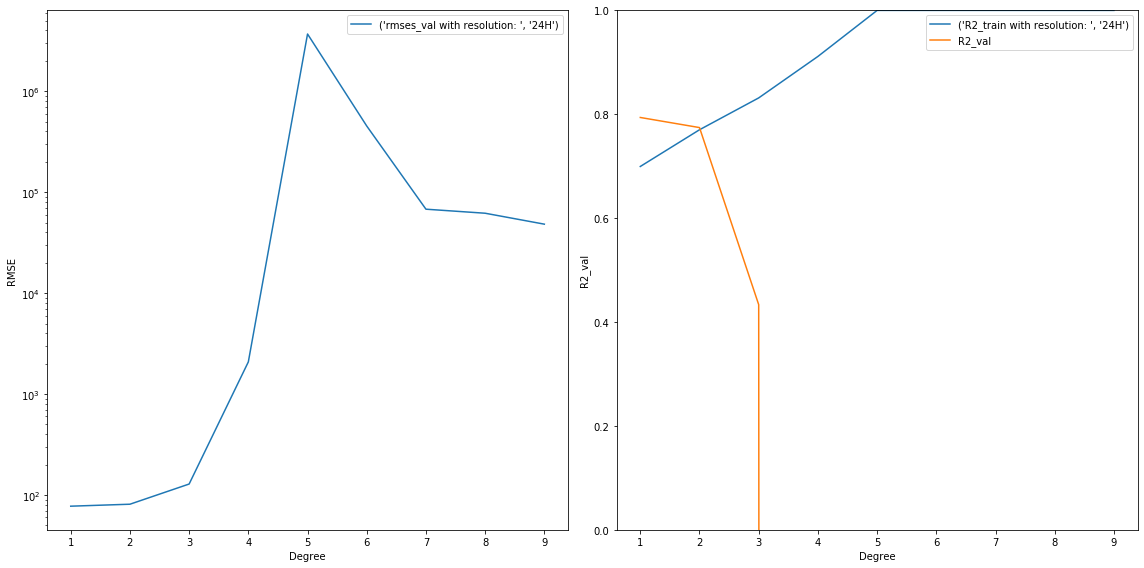

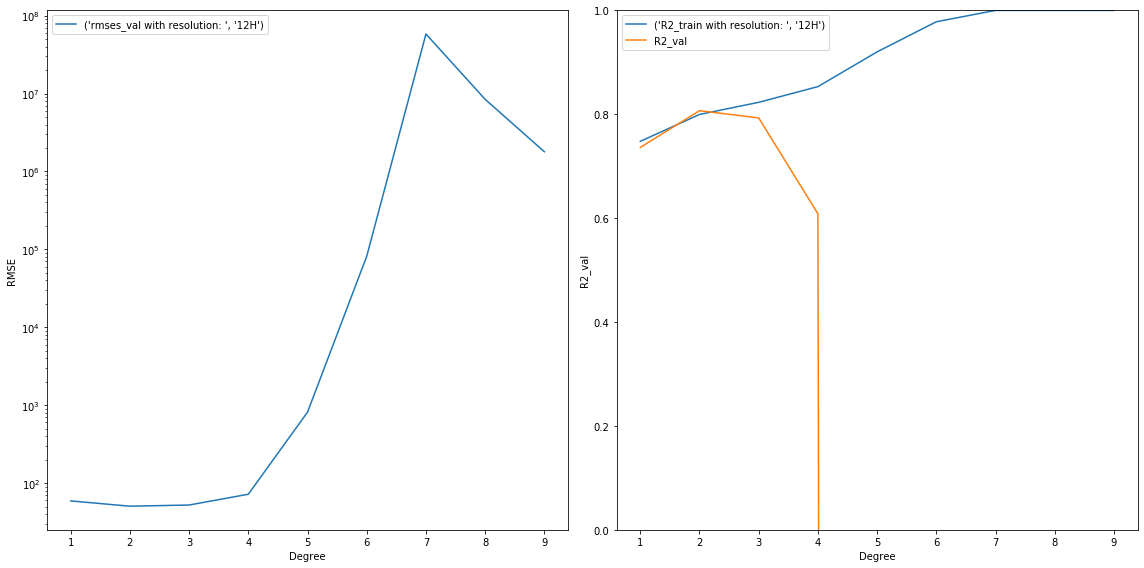

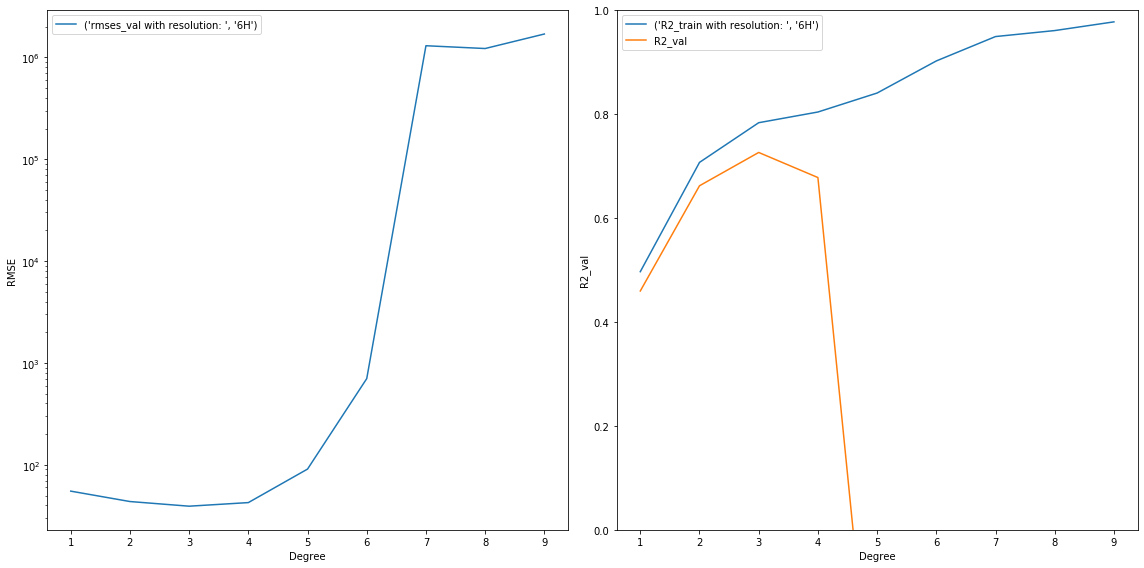

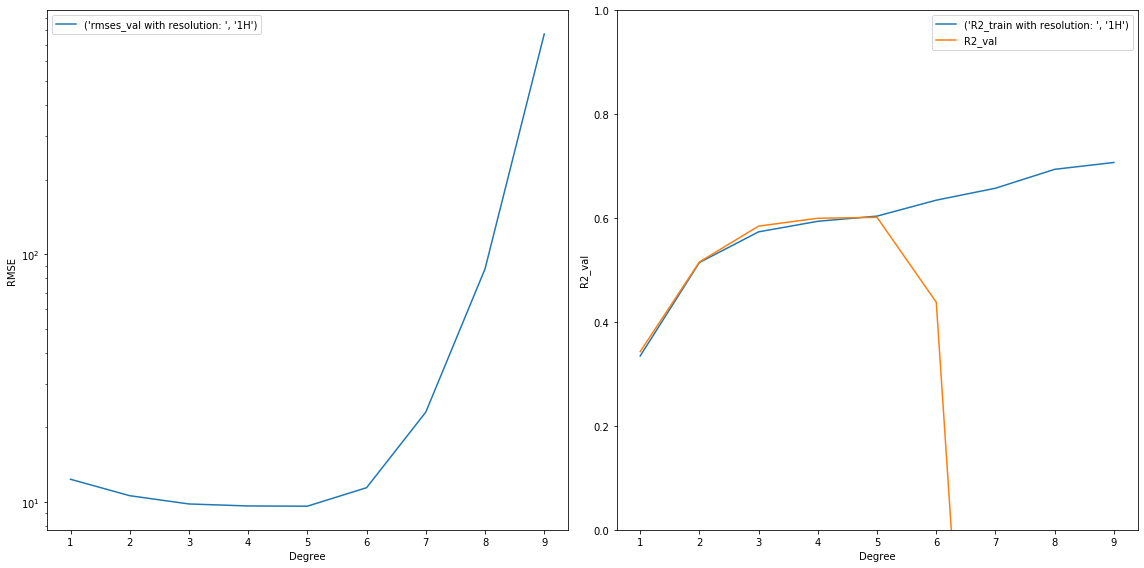

In [39]:
create_predict_test(df)